# Test de Fine Tuning de Spacy pour la tâche de NER
## Stratégie


## Conclusion


In [50]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cpu


#Préparation des Données

In [16]:
import os
import ast
from datasets import load_dataset, DatasetDict, Dataset, concatenate_datasets

#Extraction du des données depuis les csv

path = "../../data/token_classification/"

# dataset dict with emtpy attribute train
dataset = DatasetDict({'train': Dataset.from_dict({})})

for file in os.listdir(path):
    if file.endswith(".csv"):
        new_data = load_dataset('csv', data_files=path + file, delimiter=';')
        dataset["train"] = concatenate_datasets([dataset["train"], new_data["train"]])

dataset["train"] = dataset["train"].remove_columns("ner_tags").remove_columns("tokens")
print(dataset["train"][0])

{'text': "Je souhaite organiser mon trajet pour me rendre chez Hedi, qui réside à HERRLISHEIM PRÈS COLMAR, en débutant depuis l'hopital de montereau fault yonne.", 'spacy_ner_tags': "[{'start': 74, 'end': 97, 'label': 'ARR'}, {'start': 131, 'end': 152, 'label': 'DEP'}]"}


In [43]:
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))

In [44]:
show_random_elements(dataset["train"])

,text,spacy_ner_tags
0,Je cherche à me déplacer vers andelot-en-montagne depuis PERIGUEUX. Peux-tu m'aider ?,"[{'start': 30, 'end': 49, 'label': 'ARR'}, {'start': 57, 'end': 66, 'label': 'DEP'}]"
1,"Crée un itinéraire précis de BOURNONCLE-SAINT-PIERRE à la place centrale de Delémont, pour rencontrer Wanes.","[{'start': 29, 'end': 52, 'label': 'DEP'}, {'start': 76, 'end': 84, 'label': 'ARR'}]"
2,Montre-moi le chemin pour me rendre de PAYNS ABRI SAVIÈRES à Le-Verdon.,"[{'start': 39, 'end': 58, 'label': 'DEP'}, {'start': 61, 'end': 70, 'label': 'ARR'}]"
3,Comment puis-je rejoindre VALENCE VILLE à partir de l'hopital de Sete ?,"[{'start': 26, 'end': 39, 'label': 'ARR'}, {'start': 65, 'end': 69, 'label': 'DEP'}]"
4,Trouver un moyen d'atteindre la gare de Delémont depuis la gare de BOURNONCLE-SAINT-PIERRE est mon objectif.,"[{'start': 40, 'end': 48, 'label': 'ARR'}, {'start': 67, 'end': 90, 'label': 'DEP'}]"
5,Je vais à VENTIMIGLIA STAZIONE en partant de l'aéroport de MAZAMET.,"[{'start': 10, 'end': 30, 'label': 'ARR'}, {'start': 59, 'end': 66, 'label': 'DEP'}]"
6,Pourrais-tu me donner les indications pour aller d'AUBAGNE à DIJON ?,"[{'start': 52, 'end': 59, 'label': 'DEP'}, {'start': 62, 'end': 67, 'label': 'ARR'}]"
7,Comment puis-je me rendre à Bettembourg en partant de la ville de st christophe nais c. ?,"[{'start': 28, 'end': 39, 'label': 'ARR'}, {'start': 66, 'end': 89, 'label': 'DEP'}]"
8,Établis un chemin sûr de Montauban De Bretagne jusqu'à LES ARCS pour que je puisse rejoindre Liem.,"[{'start': 25, 'end': 46, 'label': 'DEP'}, {'start': 55, 'end': 63, 'label': 'ARR'}]"
9,"Serait-il possible de me rendre de la gare de LOCHES-LYCEE-ST-DENIS à Langon, s'il vous plaît ?","[{'start': 46, 'end': 67, 'label': 'DEP'}, {'start': 70, 'end': 76, 'label': 'ARR'}]"


In [41]:
import json

CONVERTED_TRAIN_DATA = []
for item in dataset["train"]:
    text = item['text']
    spacy_ner_tags = item.get('spacy_ner_tags')  # Utilisation de get pour gérer les valeurs None

    if spacy_ner_tags is not None:
        annotations = json.loads(spacy_ner_tags.replace("'", '"'))
        entities = [(annotation['start'], annotation['end'], annotation['label']) for annotation in annotations]
        CONVERTED_TRAIN_DATA.append((text, {"entities": entities}))

print(CONVERTED_TRAIN_DATA[0])
# import json
# 
# CONVERTED_TRAIN_DATA = []
# for i, item in enumerate(dataset["train"]):
#     # Arrêter la boucle après avoir traité les 10 000 premiers éléments
#     if i >= 10000:
#         break
# 
#     text = item['text']
#     spacy_ner_tags = item.get('spacy_ner_tags')  # Utilisation de get pour gérer les valeurs None
# 
#     if spacy_ner_tags is not None:
#         annotations = json.loads(spacy_ner_tags.replace("'", '"'))
#         entities = [(annotation['start'], annotation['end'], annotation['label']) for annotation in annotations]
#         CONVERTED_TRAIN_DATA.append((text, {"entities": entities}))
# 
# # Afficher le premier élément converti pour vérifier
# print(CONVERTED_TRAIN_DATA[0])

("Je souhaite organiser mon trajet pour me rendre chez Hedi, qui réside à HERRLISHEIM PRÈS COLMAR, en débutant depuis l'hopital de montereau fault yonne.", {'entities': [(74, 97, 'ARR'), (131, 152, 'DEP')]})


In [28]:
import random
from sklearn.model_selection import train_test_split

# Mélanger les données
random.shuffle(CONVERTED_TRAIN_DATA)

# Division en 70% pour l'entraînement et 30% pour le test/validation
train_data, test_valid_data = train_test_split(CONVERTED_TRAIN_DATA, test_size=0.3, random_state=42)

# Division du test/validation en deux parties égales : 15% pour le test et 15% pour la validation
test_data, valid_data = train_test_split(test_valid_data, test_size=0.5, random_state=42)

# train_data : 70% des données pour l'entraînement
# test_data : 15% des données pour le test
# valid_data : 15% des données pour la validation


In [12]:
import pycuda.driver as cuda
cuda.init()
print('Nombre de GPU disponibles :', cuda.Device.count())
for i in range(cuda.Device.count()):
    print(cuda.Device(i).name(), ' (ID :', i, ')')

Nombre de GPU disponibles : 1
Quadro T1000  (ID : 0 )


In [29]:
# Chargement du modèle pré-entrainé
import spacy
spacy.prefer_gpu(0)
nlp = spacy.load("fr_core_news_sm")


In [30]:
# recuperation du pipeline NER 
if "ner" not in nlp.pipe_names:
    ner = nlp.create_pipe("ner")
    nlp.add_pipe(ner, last=True)
else:
    ner = nlp.get_pipe("ner")


In [31]:
# Creation des différents datasets pour Spacy > 3.0 (objet Example)
from spacy.training import Example

def create_spacy_dataset(data):
    examples = []
    for text, annots in data:
        doc = nlp.make_doc(text)
        examples.append(Example.from_dict(doc, annots))
    return examples

train_examples = create_spacy_dataset(train_data)
valid_examples = create_spacy_dataset(valid_data)
test_examples = create_spacy_dataset(test_data)


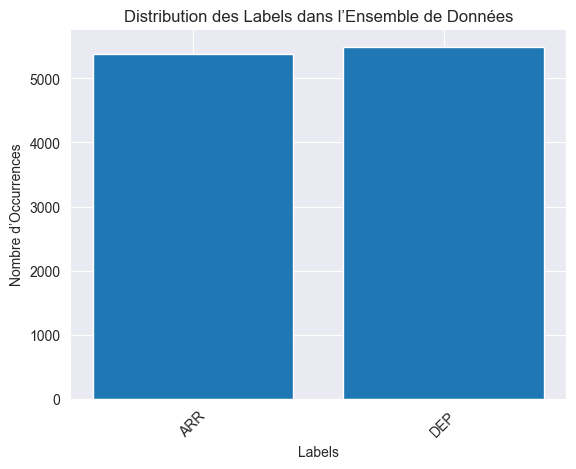

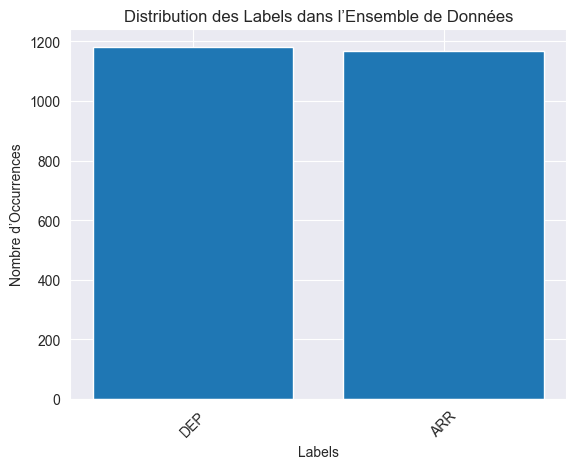

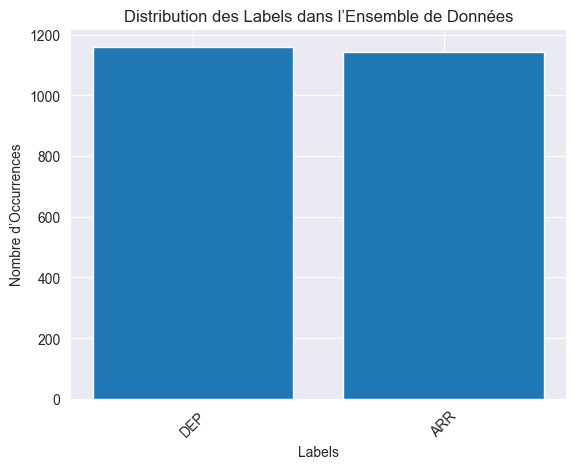

In [32]:
# Visualisation de la répartition des tag dans les données

import matplotlib.pyplot as plt
from collections import Counter

def plot_label_distribution(examples):
    # Compter les occurrences de chaque label
    label_counts = Counter([ent.label_ for example in examples for ent in example.y.ents])

    # Préparation des données pour le tracé
    labels, counts = zip(*label_counts.items())

    # Création du graphique à barres
    plt.bar(labels, counts)
    plt.xlabel('Labels')
    plt.ylabel('Nombre d’Occurrences')
    plt.title('Distribution des Labels dans l’Ensemble de Données')
    plt.xticks(rotation=45)
    plt.show()



plot_label_distribution(train_examples)  
plot_label_distribution(valid_examples)  
plot_label_distribution(test_examples)   


In [33]:
#Ajout des TAG d'entraînement au modèle (ARR, DEP)

ner.add_label("ARR")
ner.add_label("DEP")
        

1

In [34]:
#Desacativation des autres pipeline
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
with nlp.disable_pipes(*other_pipes):
    optimizer = nlp.resume_training()

Losses at iteration 0 : {'ner': 582.6488164471857}
Époque 0, F1 Score: 0.988716201830956, F1 Score for ARR: 0.9880239520958084 F1 Score for DEP: 0.9894022891055532
Losses at iteration 1 : {'ner': 474.1282815194385}
Époque 1, F1 Score: 0.9927659574468085, F1 Score for ARR: 0.9927257167308516 F1 Score for DEP: 0.9928057553956835
Losses at iteration 2 : {'ner': 401.3007361102941}
Époque 2, F1 Score: 0.9936143039591316, F1 Score for ARR: 0.9927257167308516 F1 Score for DEP: 0.9944938585345193
Losses at iteration 3 : {'ner': 449.87892852434237}
Époque 3, F1 Score: 0.9919114516815666, F1 Score for ARR: 0.9918419922713612 F1 Score for DEP: 0.9919797382861967
Losses at iteration 4 : {'ner': 400.43527468668685}
Époque 4, F1 Score: 0.9936143039591316, F1 Score for ARR: 0.9931389365351629 F1 Score for DEP: 0.9940828402366864


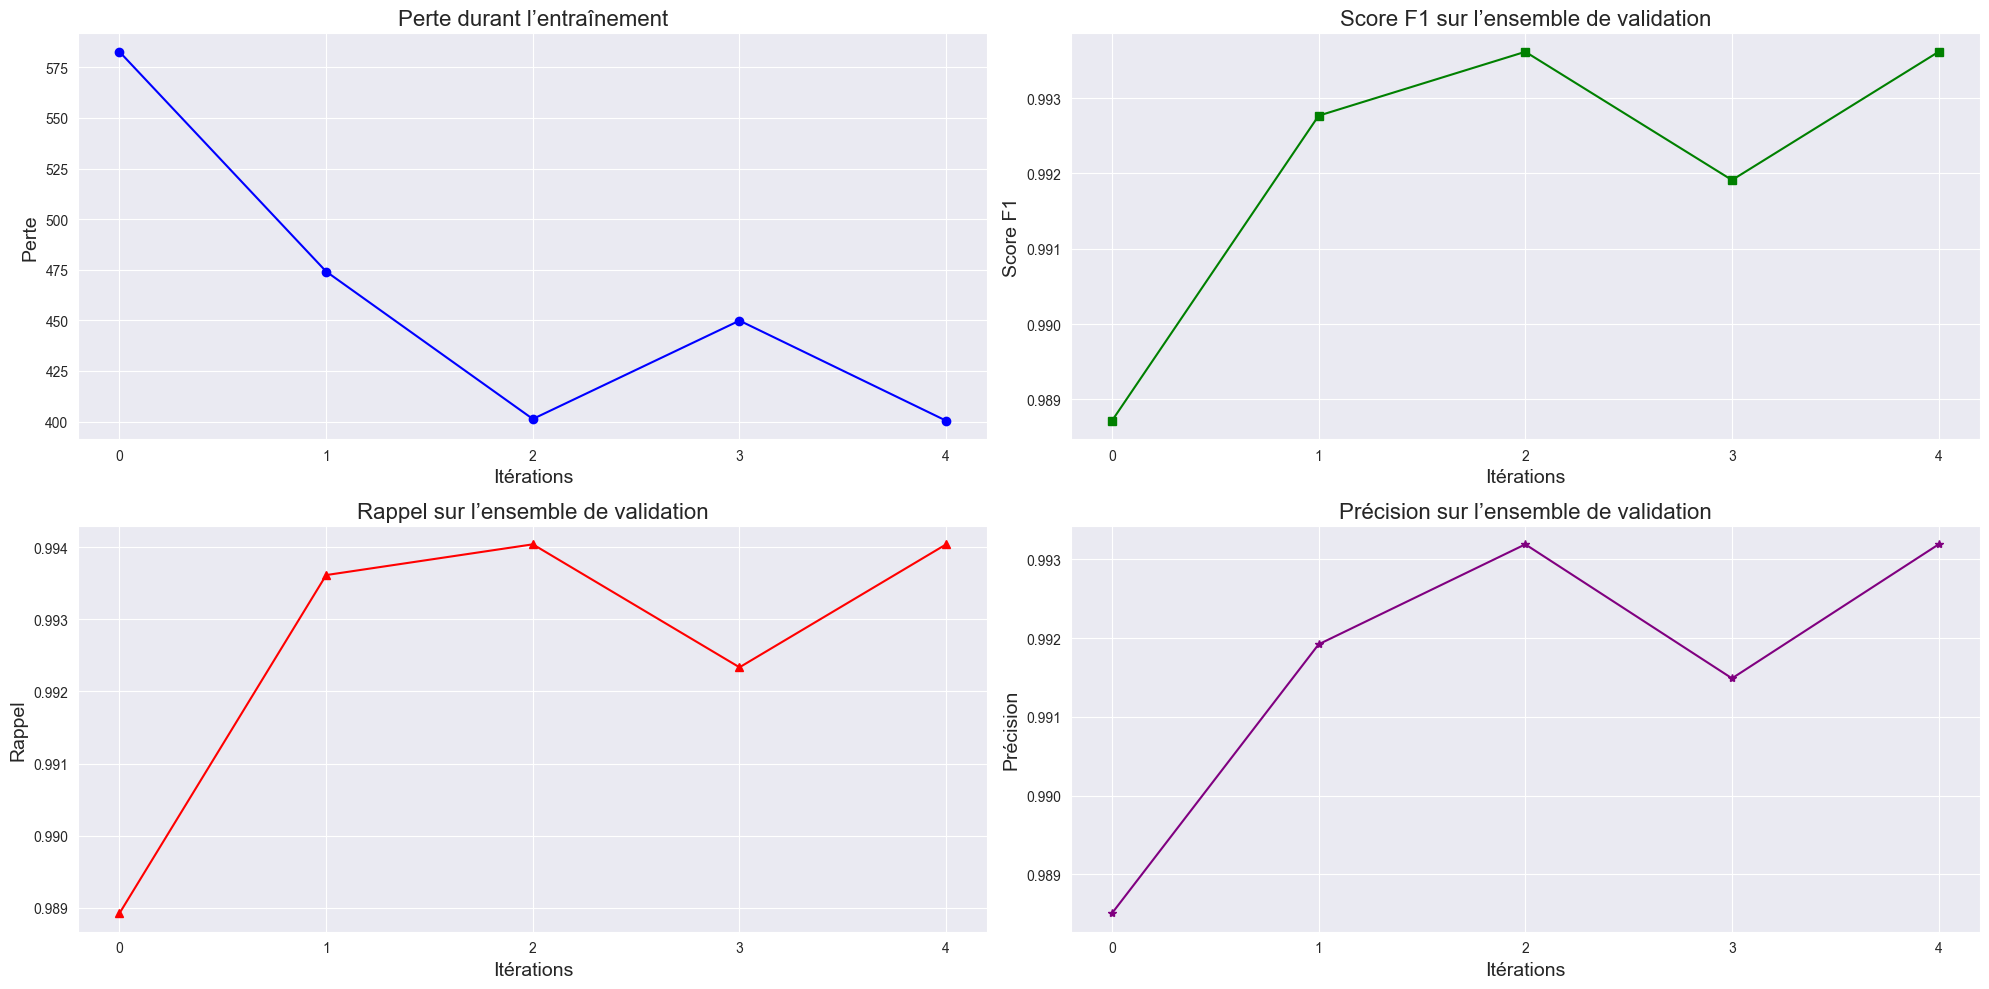

In [42]:
from spacy.scorer import Scorer
#Entrainement
import matplotlib.pyplot as plt
import random
from spacy.util import minibatch, compounding
from typing import Iterable
import numpy as np

def evaluate(nlp, examples: Iterable[Example]) -> dict:
    scorer = Scorer(nlp)  # Initialisation du Scorer avec le modèle spaCy
    examples_to_score = []
    for example in examples:
        pred_doc = nlp(example.text)  # Génération des prédictions pour le texte de l'exemple
        scored_example = Example(pred_doc, example.reference)  # Création d'un objet Example avec les prédictions
        examples_to_score.append(scored_example)
    scores = scorer.score(examples_to_score, per_component=False)  # Évaluation des exemples
    return scores

best_score = 0.0
no_improve_epochs = 0
max_no_improve_epochs = 3  # Nombre maximal d'époques sans amélioration

recall_scores = []
accuracy_scores = []
losses_list = []
f1_scores = []

# Désactivation des autres pipelines pendant l'entraînement
with nlp.disable_pipes(*[pipe for pipe in nlp.pipe_names if pipe != "ner"]):
    optimizer = nlp.resume_training()  #nlp.begin_training()
    for i in range(5):  # Nombre d'itérations, ajustez selon vos besoins
        random.shuffle(train_examples)
        losses = {}
        # Création de lots avec spaCy's minibatch et compounding
        batches = minibatch(train_examples, size=compounding(4., 32., 1.001))
        for batch in batches:
            # Mise à jour du modèle avec les exemples du batch
            nlp.update(batch, drop=0.5, losses=losses, sgd=optimizer)
        print("Losses at iteration", i, ":", losses)
        losses_list.append(losses['ner'])

        # Évaluation et collecte des métriques
        scores = evaluate(nlp, valid_examples)
        # scores = evaluate(nlp, valid_examples)
        f1_score = scores['ents_f']
        arr_f1_score = scores['ents_per_type']['ARR']['f']
        dep_f1_score = scores['ents_per_type']['DEP']['f']
        f1_scores.append(f1_score)
        
        recall_score = scores['ents_r']
        precision_score = scores['ents_p']  # Précision utilisée comme approximation de l'accuracy dans ce contexte
        recall_scores.append(recall_score)
        accuracy_scores.append(precision_score)

        print(f"Époque {i}, F1 Score: {f1_score}, F1 Score for ARR: {arr_f1_score} F1 Score for DEP: {dep_f1_score}")

        # Early Stopping
        if f1_score > best_score:
            best_score = f1_score
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1

        if no_improve_epochs >= max_no_improve_epochs:
            print(f"Arrêt précoce après {i} époques.")
            break

plt.figure(figsize=(20, 10))  # Ajustez la taille du graphique selon vos besoins

# Graphique de la perte
plt.subplot(2, 2, 1)
plt.plot(losses_list, marker='o', linestyle='-', color='blue')
plt.xlabel('Itérations', fontsize=14)
plt.ylabel('Perte', fontsize=14)
plt.title('Perte durant l’entraînement', fontsize=16)
plt.xticks(np.arange(0, len(losses_list), step=1))  # Assurez-vous que l'axe x a des graduations entières

# Graphique du score F1
plt.subplot(2, 2, 2)
plt.plot(f1_scores, marker='s', linestyle='-', color='green')
plt.xlabel('Itérations', fontsize=14)
plt.ylabel('Score F1', fontsize=14)
plt.title('Score F1 sur l’ensemble de validation', fontsize=16)
plt.xticks(np.arange(0, len(f1_scores), step=1))  # Répétez pour chaque graphique

# Graphique du rappel
plt.subplot(2, 2, 3)
plt.plot(recall_scores, label='Rappel', marker='^', linestyle='-', color='red')
plt.xlabel('Itérations', fontsize=14)
plt.ylabel('Rappel', fontsize=14)
plt.title('Rappel sur l’ensemble de validation', fontsize=16)
plt.xticks(np.arange(0, len(recall_scores), step=1))

# Graphique de la précision
plt.subplot(2, 2, 4)
plt.plot(accuracy_scores, label='Précision', marker='*', linestyle='-', color='purple')
plt.xlabel('Itérations', fontsize=14)
plt.ylabel('Précision', fontsize=14)
plt.title('Précision sur l’ensemble de validation', fontsize=16)
plt.xticks(np.arange(0, len(accuracy_scores), step=1))

plt.tight_layout()  # Ajuste automatiquement les sous-graphiques pour qu'ils rentrent dans la figure
plt.show()



In [53]:
from pathlib import Path

# Définir le répertoire courant comme emplacement de sauvegarde
output_dir = Path(".") / "pre_trained_spacy_model"

# Créer le dossier de sauvegarde s'il n'existe pas
output_dir.mkdir(parents=True, exist_ok=True)

# Sauvegarder le modèle spaCy dans le dossier créé
nlp.to_disk(output_dir)
print(f"Modèle sauvegardé dans {output_dir.absolute()}")


Modèle sauvegardé dans D:\EpitechProjects\T-AIA-901\T-AIA-901\ai\token-classification\spacy\pre_trained_spacy


In [22]:
#Evaluation sur les données de test
test_scores = evaluate(nlp, test_examples)
print(test_scores)


{'token_acc': 1.0, 'token_p': 1.0, 'token_r': 1.0, 'token_f': 1.0, 'pos_acc': None, 'morph_acc': None, 'morph_micro_p': None, 'morph_micro_r': None, 'morph_micro_f': None, 'morph_per_feat': None, 'sents_p': None, 'sents_r': None, 'sents_f': None, 'dep_uas': None, 'dep_las': None, 'dep_las_per_type': None, 'tag_acc': None, 'lemma_acc': None, 'ents_p': 0.9715901158732375, 'ents_r': 0.9603189465695503, 'ents_f': 0.9659216520191731, 'ents_per_type': {'DEP': {'p': 0.9740079365079365, 'r': 0.9598576540288993, 'f': 0.9668810257723328}, 'ARR': {'p': 0.9691471873621748, 'r': 0.9607878209714603, 'f': 0.9649494001876284}}}


In [60]:
from collections import defaultdict
import pandas as pd

def calculate_ner_confusion_matrix(examples, nlp):
    # Initialisation des compteurs pour chaque type d'entité
    true_positives = defaultdict(int)
    false_positives = defaultdict(int)
    false_negatives = defaultdict(int)

    for example in examples:
        # Texte original et annotations de référence
        text = example.text
        reference_ents = example.reference.ents

        # Prédiction du modèle
        pred_doc = nlp(text)
        pred_ents = pred_doc.ents

        # Conversion en sets pour faciliter la comparaison
        ref_set = {(ent.start_char, ent.end_char, ent.label_) for ent in reference_ents}
        pred_set = {(ent.start_char, ent.end_char, ent.label_) for ent in pred_ents}

        # Calcul des vrais positifs, faux positifs et faux négatifs
        for ent in pred_set:
            if ent in ref_set:
                true_positives[ent[2]] += 1
            else:
                false_positives[ent[2]] += 1

        for ent in ref_set:
            if ent not in pred_set:
                false_negatives[ent[2]] += 1

    return true_positives, false_positives, false_negatives

# Exemple d'utilisation
true_positives, false_positives, false_negatives = calculate_ner_confusion_matrix(valid_examples, nlp)


In [61]:
def display_confusion_matrix(true_positives, false_positives, false_negatives):
    # Création d'un DataFrame pour l'affichage
    labels = set(true_positives) | set(false_positives) | set(false_negatives)
    data = []
    for label in labels:
        tp = true_positives.get(label, 0)
        fp = false_positives.get(label, 0)
        fn = false_negatives.get(label, 0)
        data.append({"Label": label, "Vrais Positifs": tp, "Faux Positifs": fp, "Faux Négatifs": fn})

    df = pd.DataFrame(data)
    df.set_index("Label", inplace=True)
    print(df)

# Exemple d'affichage
display_confusion_matrix(true_positives, false_positives, false_negatives)


       Vrais Positifs  Faux Positifs  Faux Négatifs
Label                                              
ARR              1115            215             52
DEP              1128            221             53


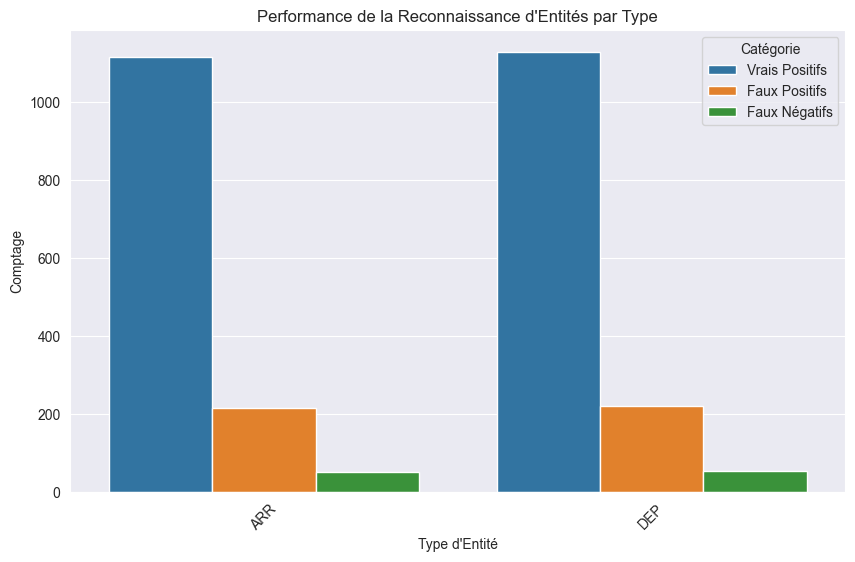

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Supposons que vous ayez déjà calculé true_positives, false_positives, et false_negatives

# Préparation des données pour la visualisation
data = {
    "Type d'Entité": [],
    "Comptage": [],
    "Catégorie": []
}
labels = set()
for example in valid_examples:
    for ent in example.reference.ents:
        labels.add(ent.label_)
        
# Ajouter les données de chaque catégorie pour chaque label
for label in labels:
    data["Type d'Entité"].extend([label]*3)
    data["Comptage"].extend([
        true_positives.get(label, 0),
        false_positives.get(label, 0),
        false_negatives.get(label, 0)
    ])
    data["Catégorie"].extend(["Vrais Positifs", "Faux Positifs", "Faux Négatifs"])

df = pd.DataFrame(data)

# Visualisation avec Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x="Type d'Entité", y="Comptage", hue="Catégorie", data=df)
plt.xticks(rotation=45)
plt.title("Performance de la Reconnaissance d'Entités par Type")
plt.show()


In [49]:
# Shuffle train dataset, and pick 30% of it
train_data = dataset['train']
train_data = train_data.shuffle(seed=42)
train_data = train_data.train_test_split(test_size=0.7)['train']

# Split so we have 10% of train, 81% of test and 9% of valid
train_test_valid = train_data.train_test_split(test_size=0.9)
test_valid = train_test_valid['test'].train_test_split(test_size=0.9)

dataset = DatasetDict({
    'train': train_test_valid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']
})

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'spacy_ner_tags'],
        num_rows: 13071
    })
    test: Dataset({
        features: ['text', 'spacy_ner_tags'],
        num_rows: 105878
    })
    valid: Dataset({
        features: ['text', 'spacy_ner_tags'],
        num_rows: 11764
    })
})

# Matrice de confusion

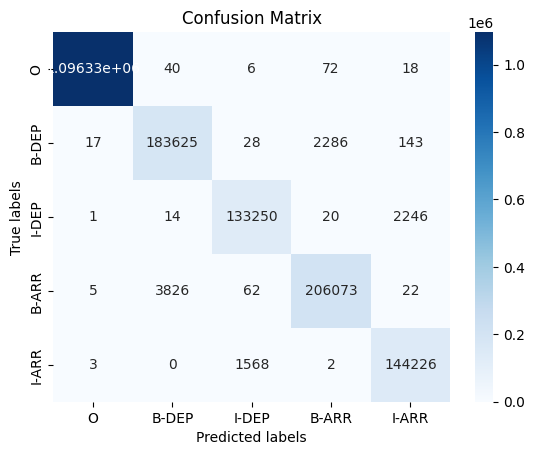

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

flat_y_true = [item for sublist in y_true for item in sublist]
flat_y_pred = [item for sublist in y_pred for item in sublist]

cm = confusion_matrix(flat_y_true, flat_y_pred, labels=label_list)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=label_list, yticklabels=label_list)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Matrice de confusion sans le label O

In [63]:
def get_locations_from_outputs(sentence, outputs):
    # Initialisation des listes pour stocker les localisations de départ et d'arrivée
    departures = []
    arrivals = []

    # Analyse des sorties pour extraire les entités pertinentes
    for output in outputs:
        # Exemple d'analyse basée sur les labels retournés par votre modèle
        if output['entity_group'] == 'DEP':  # Supposons que 'DEP' est le label pour les points de départ
            departures.append(output['word'])
        elif output['entity_group'] == 'ARR':  # Supposons que 'ARR' est le label pour les points d'arrivée
            arrivals.append(output['word'])

    # Retourne un dictionnaire avec les départ et arrivée identifiés
    return {'departures': departures, 'arrivals': arrivals}

def get_locations_from_doc(doc):
    departures = []
    arrivals = []

    for ent in doc.ents:
        if ent.label_ == "DEP":  # Assumer que 'DEP' est le label pour les points de départ
            departures.append(ent.text)
        elif ent.label_ == "ARR":  # Assumer que 'ARR' est le label pour les points d'arrivée
            arrivals.append(ent.text)

    return {"departures": departures, "arrivals": arrivals}


In [64]:
sentences = [
    "Je veux aller de Port-Boulet à Le Havre.",
    "Je vais de Port-Boulet à Le Havre.",
    "Peux-tu m'aider à trouver mon chemin vers Paris en partant d'Épierre ?",
    "Je cherche un moyen d'aller de Margny-Lès-Compiègne à Saarbrücken /Sarrebruck.",
    "Je veux me rendre chez mon ami Etienne à Saint-Étienne depuis Nantes.",
    "Je veux aller de la ville de Marseille à Tours.",
    "Recherche le chemin le plus court entre la ville de Lorient et Paris",
    "Trouve un itinéraire pour aller à Besançon depuis la ville de Oyonnax.",
    "Nantes à Toulouse",
]

# Traitement des phrases avec le modèle spaCy et extraction des localisations
for sentence in sentences:
    doc = nlp(sentence)
    locations = get_locations_from_doc(doc)
    print(locations)


{'departures': ['Port-Boulet'], 'arrivals': ['Le Havre']}
{'departures': ['Port-Boulet'], 'arrivals': ['Le Havre']}
{'departures': ['Épierre'], 'arrivals': ['Paris']}
{'departures': ['Margny-Lès-Compiègne', 'Saarbrücken /Sarrebruck'], 'arrivals': []}
{'departures': ['Nantes'], 'arrivals': ['Saint-Étienne']}
{'departures': ['Tours'], 'arrivals': ['Marseille']}
{'departures': ['Lorient', 'Paris'], 'arrivals': []}
{'departures': [], 'arrivals': ['Besançon', 'Oyonnax']}
{'departures': ['Nantes'], 'arrivals': ['Toulouse']}
